In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
import hdf5storage as h5mat
import h5py as h5
import subprocess
import sys
import time

## function to produce 2d model with dip

In [2]:
def rand_2d_dipping(nx=600,nz=200,dx=10,dz=10,vmin=1500,vmax=4500,dvmin=-600,dvmax=600,minthick=500,maxthick=1000,maxdip=20): 
    #pick random dip
    dip = (np.random.random_sample()-0.5)*2*maxdip
    
    #calculate padding so we have layers throughout model even with dip
    pad_z = int(dx*nx*math.tan(math.fabs(dip)/360*2*math.pi)/dz)
    nz_orig = nz
    nz = nz+2*pad_z
    
    # Random draw of nz velocities (velocities as factor of 10
    dvel = (np.random.randint(dvmin/10,dvmax/10,nz))*10
    vel = np.zeros(nz)
    vel[0] = vmin
    for i in np.arange(nz)-1:
        vel[i+1] = ((vmax-vmin)/nz*i+vmin+vel[i])/2 + dvel[i]
        
    # Make 1D layer cake earth model blocky with psuedo-random thickness interval
    minthick=minthick/dz
    maxthick=maxthick/dz
    last_index = 0
    vel_block = np.zeros(vel.shape)
    while True:
        thick_pixels = int(np.random.randint(minthick,maxthick, size=1)/dz)
        if last_index+thick_pixels >= nz:
            vel_block[last_index:] = np.sum(vel[last_index:])/(nz-last_index)
            break
        else:
            vel_block[last_index:last_index+thick_pixels] = np.sum(vel[last_index:last_index+thick_pixels])/thick_pixels
        last_index = last_index + thick_pixels
    
    # make 2D layer cakde from blocky layer cake with some dip
    
    vel_2D = np.zeros((nz,nx))
    #print vel_2D.shape
    shift_constant = math.tan(dip/360*2*math.pi)/dz
    #print dip
    for i in np.arange(nx):
        cur_dx = dx*i #float shift in x direction
        pixel_shift = int(cur_dx*shift_constant)
        if pixel_shift >= 0:
            vel_2D[pixel_shift:,i]=vel_block[:vel_block.shape[0]-pixel_shift]
        else:
            #vel_2D[:,i]=vel_block
            vel_2D[:pixel_shift,i]=vel_block[-pixel_shift:]
            
    return vel_2D[pad_z:pad_z+nz_orig,:]-np.mean(vel_2D[pad_z:pad_z+nz_orig,:])+3500

## Generate model np array

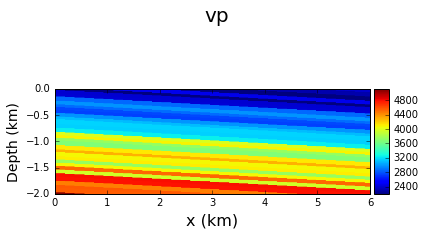

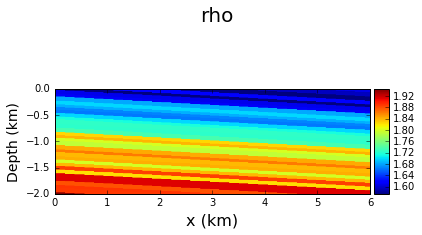

In [3]:
nx=600
nz=200
alpha=0.23
beta=0.25
model_shape = (nz,nx)
models={
        'vp':None,
        'vs':None, 
        'rho':None}

models['vp'] = rand_2d_dipping(nx,nz)
models['vs'] = models['vp']/1.8
models['rho'] = alpha*models['vp']**beta

for par in ['vp','vs','rho']:  
    fig, ax = plt.subplots()
    fig.suptitle(par, fontsize=20)
    plt.xlabel('x (km)', fontsize=16)
    plt.ylabel('Depth (km)', fontsize=14)
    im = ax.imshow(models[par], 
                   extent=[0,models[par].shape[1]*0.01,-models[par].shape[0]*0.01,0])
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    plt.colorbar(im, cax=cax)
    
    plt.show()

## SeisCL input files

In [4]:
file="SeisCL"
filenames={}
filenames['model']=file+"_model.mat"    #File containing the model pareters
filenames['csts']=file+"_csts.mat"      #File containing the simulation constants
filenames['din']=file+"_din.mat"        #File containing the recorded data

## SeicCL output files

In [5]:
filenames['dout']=file+"_dout.mat"      #File containing the seismograms output
filenames['gout']=file+"_gout.mat"      #File containing the gradient ouput
filenames['rms']=file+"_rms.mat"        #File containing the rms ouput
filenames['movout']=file+"_movie.mat"   #File containing the movie ouput

## make constants input file, 'csts'

In [6]:
length_t=1.28*1

In [7]:
csts={}
csts['NX']=models['vp'].shape[1]              #Grid size in X
csts['NY']=1                #Grid size in Y (set to 1 for 2D)
csts['NZ']=models['vp'].shape[0]              #Grid size in Z
csts['ND']=2                #Flag for dimension. 3: 3D, 2: 2D P-SV,  21: 2D SH
csts['dh']=10             #Grid spatial spacing
csts['dt']=6*csts['dh']/(7*np.sqrt(2)*np.max(models['vp']))*0.95/2# Time step size
#csts['dt']=0.001# Time step size
csts['NT']=int(len(np.arange(-length_t/2, (length_t-csts['dt'])/2, csts['dt']))) #Number of time steps
csts['freesurf']=0          #Include a free surface at z=0: 0: no, 1: yes
csts['FDORDER']=4           #Order of the finite difference stencil. Values: 2,4,6,8,10,12
csts['MAXRELERROR']=1       #Set to 1
csts['L']=0                #Number of attenuation mechanism (L=0 elastic)
csts['f0']=10               #Central frequency for which the relaxation mechanism are corrected to the righ velocity
csts['FL']=np.array(5)     #Array of frequencies in Hz of the attenuation mechanism

csts['src_pos']=np.empty((5,0)) #Position of each shots. 5xnumber of sources. [sx sy sz srcid src_type]. srcid is the source number (two src with same srcid are fired simulatneously) src_type: 1: Explosive, 2: Force in X, 3: Force in Y, 4:Force in Z
csts['rec_pos']=np.empty((8,0)) #Position of the receivers. 8xnumber of traces. [gx gy gz srcid recid Not_used Not_used Not_used]. srcid is the source number recid is the trace number in the record
csts['src']=np.empty((csts['NT'],0))            #Source signals. NTxnumber of sources

csts['abs_type']=1          #Absorbing boundary type: 1: CPML, 2: Absorbing layer of Cerjan
csts['VPPML']=4000          #Vp velocity near CPML boundary
csts['NPOWER']=2            #Exponent used in CMPL frame update, the larger the more damping
csts['FPML']=5              #Dominant frequency of the wavefield
csts['K_MAX_CPML']=2        #Coeffienc involved in CPML (may influence simulation stability)
csts['nab']=16              #Width in grid points of the absorbing layer
csts['abpc']=6              #Exponential decay of the absorbing layer of Cerjan et. al.
csts['pref_device_type']=4  #Type of processor used: 2: CPU, 4: GPU, 8: Accelerator
csts['nmax_dev']=8       #Maximum number of devices that can be used
csts['no_use_GPUs']=np.empty( (1,0) )  #Array of device numbers that should not be used for computation
csts['MPI_NPROC_SHOT']=1    #Maximum number of MPI process (nodes) per shot involved in domain decomposition

csts['back_prop_type']=2    #Type of gradient calculation: 1: backpropagation (elastic only) 2: Discrete Fourier transform
csts['par_type']=0        #Type of paretrization: 0:(rho,vp,vs,taup,taus), 1:(rho, M, mu, taup, taus), 2:(rho, Ip, Is, taup, taus)
csts['gradfreqs']=np.empty((1,0)) #Array of frequencies in Hz to calculate the gradient with DFT
csts['tmax']=csts['NT']*csts['dt']#Maximum time for which the gradient is to be computed
csts['tmin']=0              #Minimum time for which the gradient is to be computed
csts['scalerms']=0          #Scale each modeled and recorded traces according to its rms value, then scale residual by recorded trace rms
csts['scalermsnorm']=0      #Scale each modeled and recorded traces according to its rms value, normalized
csts['scaleshot']=0         #Scale all of the traces in each shot by the shot total rms value
csts['fmin']=0              #Maximum frequency for the gradient computation
csts['fmax']=45              #Minimum frequency for the gradient computation
csts['mute']=None           #Muting matrix 5xnumber of traces. [t1 t2 t3 t4 flag] t1 to t4 are mute time with cosine tapers, flag 0: keep data in window, 1: mute data in window
csts['weight']=None         # NTxnumber of geophones or 1x number of geophones. Weight each sample, or trace, according to the value of weight for gradient calculation.

csts['gradout']=0           #Output gradient 1:yes, 0: no
csts['gradsrcout']=0        #Output source gradient 1:yes, 0: no
csts['seisout']=2           #Output seismograms 1:velocities, 2: pressure, 3: velocities and pressure, 4: velocities and stresses
csts['resout']=0            #Output residuals 1:yes, 0: no
csts['rmsout']=0            #Output rms value 1:yes, 0: no
csts['movout']=0            #Output movie 1:yes, 0: no
csts['restype']=0           #Type of costfunction 0: raw seismic trace cost function. No other available at the moment

print(csts)

{'f0': 10, 'back_prop_type': 2, 'NPOWER': 2, 'fmin': 0, 'no_use_GPUs': array([], shape=(1, 0), dtype=float64), 'dh': 10, 'tmin': 0, 'nmax_dev': 8, 'movout': 0, 'tmax': 1.2797300496341528, 'NY': 1, 'MPI_NPROC_SHOT': 1, 'scaleshot': 0, 'pref_device_type': 4, 'MAXRELERROR': 1, 'dt': 0.0005620246155617711, 'NX': 600, 'gradsrcout': 0, 'mute': None, 'L': 0, 'src': array([], shape=(2277, 0), dtype=float64), 'restype': 0, 'resout': 0, 'gradfreqs': array([], shape=(1, 0), dtype=float64), 'K_MAX_CPML': 2, 'fmax': 45, 'freesurf': 0, 'FPML': 5, 'NT': 2277, 'ND': 2, 'VPPML': 4000, 'rec_pos': array([], shape=(8, 0), dtype=float64), 'abs_type': 1, 'nab': 16, 'NZ': 200, 'seisout': 2, 'par_type': 0, 'src_pos': array([], shape=(5, 0), dtype=float64), 'rmsout': 0, 'scalermsnorm': 0, 'scalerms': 0, 'weight': None, 'FL': array(5), 'gradout': 0, 'abpc': 6, 'FDORDER': 4}


## make model input file, 'model'


In [8]:
models['vp']=np.reshape(models['vp'], [csts['NZ'],csts['NY'],csts['NX']]) 
models['vs']=np.reshape(models['vs'], [csts['NZ'],csts['NY'],csts['NX']])
models['rho']=np.reshape(models['rho'], [csts['NZ'],csts['NY'],csts['NX']])

## make source signature

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(2277, 1)


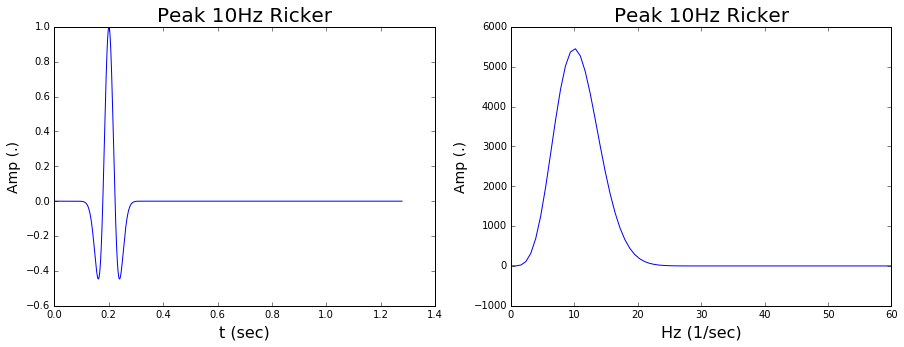

In [9]:
f_peak=csts['f0']
t_min = -2/(f_peak)
length=length_t
dt=csts['dt']
df=dt/length/dt
t = np.arange(-length/2, (length-dt)/2, dt)
#t = np.arange(t_min, -t_min, dt)
y = (1.0 - 2.0*(np.pi**2)*(f_peak**2)*(t**2)) * np.exp(-(np.pi**2)*(f_peak**2)*(t**2))
hz = np.fft.fft(y)[:y.shape[0]/2]
f = np.arange(0,hz.shape[0]*df,df)

#shift so spike is at beginning 
shift_flt = -(length/2)-t_min
shift_int = int(shift_flt/dt)
t += length/2
ricker = np.roll(y,int(shift_int))

#plot
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,2,1, adjustable='box')
ax2 = fig.add_subplot(1,2,2,adjustable='box')

ax1.plot(t,ricker)
ax1.set_title('Peak ' + str(f_peak) + 'Hz Ricker' , fontsize=20)
ax1.set_xlabel('t (sec)', fontsize=16)
ax1.set_ylabel('Amp (.)', fontsize=14)

ax2.plot(f,hz*hz)
ax2.set_xlim([0,60])
ax2.set_title('Peak ' + str(f_peak) + 'Hz Ricker' , fontsize=20)
ax2.set_xlabel('Hz (1/sec)', fontsize=16)
ax2.set_ylabel('Amp (.)', fontsize=14)

ricker = np.reshape(ricker,[len(ricker),1])
print(ricker.shape)

## assign to source and receiver locations

In [10]:
src_os_f=0 #FLOAT of first shot without abs boundary padding
src_ds_f=250 #FLOAT spacing between shots
src_ds_i=int(src_ds_f/csts['dh']) #INDEX spacing between shots
src_os_i= int(src_os_f/csts['dh']) #INDEX of first shot without abs boundary padding
src_os_i_actual = int(src_os_i + csts['nab']) #INDEX of first shot with abs boundary padding
src_ns= int(csts['NX']*csts['dh']/src_ds_f)+1

sx=np.zeros( src_ns )
sz=np.zeros( src_ns )
for i in np.arange(src_ns):
    sx[i] = src_os_i_actual*csts['dh'] + src_ds_f*i
    sz[i] = 10   
print(sx)
    
rec_os_f=0 #FLOAT of first shot without abs boundary padding
rec_ds_f=10 #FLOAT spacing between shots
rec_ds_i=int(rec_ds_f/csts['dh']) #INDEX spacing between shots
rec_os_i= int(rec_os_f/csts['dh']) #INDEX of first shot without abs boundary padding
rec_os_i_actual = int(rec_os_i + csts['nab']) #INDEX of first shot with abs boundary padding
rec_ns= int(csts['NX']*csts['dh']/rec_ds_f)

gx=np.zeros( rec_ns )
gz=np.zeros( rec_ns )
for i in np.arange(rec_ns):
    gx[i] = rec_os_i_actual*csts['dh'] + rec_ds_f*i
    gz[i] =  190*csts['dh']
#print(gx)
#print(gz)

[  160.   410.   660.   910.  1160.  1410.  1660.  1910.  2160.  2410.
  2660.  2910.  3160.  3410.  3660.  3910.  4160.  4410.  4660.  4910.
  5160.  5410.  5660.  5910.  6160.]


In [11]:
for ii in range(csts['nab']+5,csts['NX']-2*csts['nab']-10,100):
#for ii in range(src_ns):
    toappend=np.zeros((5,1))
    toappend[0,:]=ii*csts['dh']         # x position
    print(ii*csts['dh'] )
    #toappend[0,:]=sx[ii]
    toappend[1,:]=0                # y position
    toappend[2,:]=(6)*csts['dh']          # z position
    toappend[3,:]=ii               # Source id
    toappend[4,:]=2              # source type
    csts['src_pos']=np.append(csts['src_pos'], toappend, axis=1)
    csts['src']=np.append(csts['src'], ricker  , axis=1)
    
    toappend=np.stack([gx,      # x position
                       gx*0,    # y position
                       gz,      # z position
                       gz*0+ii, # source id  
                       np.arange(0,len(gx))+csts['rec_pos'].shape[1], # rec id (unique to each receiver)
                       gx*0,    # For future use
                       gx*0,    # For future use
                       gx*0],   # For future use
                       0)
    csts['rec_pos']=np.append(csts['rec_pos'], toappend, axis=1)
print(csts['src_pos'].shape)

210
1210
2210
3210
4210
5210
(5, 6)


In [12]:
#print(csts['src_pos'])

In [13]:
%%bash
rm err
rm out
rm SeisCL_csts.mat
rm SeisCL_dout.mat
rm SeisCL_model.mat

## save modeling parameters and models to file

In [14]:
time.sleep(1)
h5mat.savemat(filenames['csts'], 
              csts , 
              appendmat=False, format='7.3', 
              store_python_metadata=True, 
              truncate_existing=True)
h5mat.savemat(filenames['model'], 
              models , 
              appendmat=False, 
              format='7.3', 
              store_python_metadata=True, 
              truncate_existing=True)
time.sleep(1)

In [15]:

filepath=os.getcwd()
seisCLpath = '/net/server/homes/sep/stuart/projects/SeisCL/src/SeisCL_MPI'
cmdlaunch='mpirun -np 1 '+ seisCLpath + ' '+ filepath +'/'+file+' > '+filepath+'/out 2>'+filepath+'/err'
cmdlaunch

'mpirun -np 1 /net/server/homes/sep/stuart/projects/SeisCL/src/SeisCL_MPI /net/server/homes/sep/stuart/courses/CS230/project/velocitynn/python/SeisCL > /net/server/homes/sep/stuart/courses/CS230/project/velocitynn/python/out 2>/net/server/homes/sep/stuart/courses/CS230/project/velocitynn/python/err'

In [16]:
start = time.time()

pipes = subprocess.Popen(cmdlaunch,stdout=subprocess.PIPE, stderr=subprocess.PIPE,shell=True)
while (pipes.poll() is None):
    time.sleep(0.2)
end = time.time()
print(end - start)
sys.stdout.write('Forward calculation completed \n')
sys.stdout.flush()

94.14363598823547
Forward calculation completed 


<HDF5 file "SeisCL_dout.mat" (mode r)>
<HDF5 dataset "pout": shape (3600, 2277), type "<f8">
(2277, 3600)


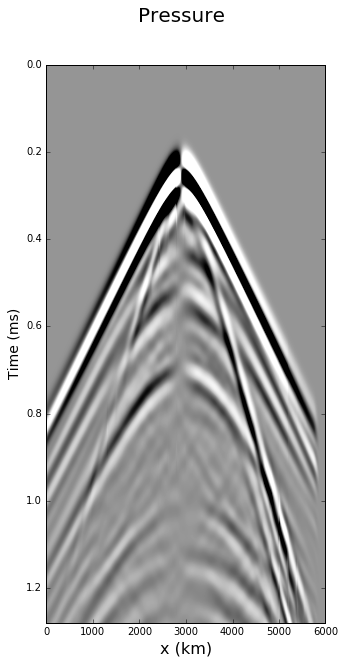

1.27303225739e-08


In [21]:
dout = h5.File('SeisCL_dout.mat','r')

print(dout)
# vx_el=dout['vxout']
# print(vx_el)
# vx_el=np.transpose(vx_el[:,:]) 
p_el=dout['pout']
print(p_el)
p_el=np.transpose(p_el[:,:])
print(p_el.shape)

clip=.1;
shot=4
min_i=shot*600
max_i=(shot+1)*600-1
p_el = p_el[:,min_i:max_i]
vmin=np.min(p_el)*clip;
vmax=np.max(p_el)*clip;
fig, ax = plt.subplots(figsize=(5,10))
im = ax.imshow(p_el[:,:], 
               interpolation='bilinear', 
               vmin=vmin, 
               vmax=vmax, 
               cmap=plt.get_cmap('Greys'), 
               aspect='auto',
               origin='upper',
               extent=[0,csts['dh']*p_el.shape[1], p_el.shape[0]*csts['dt'],0]
               )
fig.suptitle('Pressure', fontsize=20)
plt.xlabel('x (km)', fontsize=16)
plt.ylabel('Time (ms)', fontsize=14)
plt.show()
print(np.max(p_el))